In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from xgcm import Grid
import seawater
import seaborn as sns


os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
forcing=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_force_month.zarr.zip')
forcing=forcing.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
forcing=forcing.rename({'xt_ocean':'lon','yt_ocean':'lat'})

forcing['lon']=forcing['lon']+360
forcing['lon_x']=forcing['lon_x']+360

forcing=forcing.sel(lon=slice(120,290),lat=slice(-40,40))
forcing['time']=forcing.time.astype('datetime64[M]')

forcing=forcing.sel(time=slice('2000','2020')).sel(ensemble=25,method='nearest')


In [3]:
atmos=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip')
#atmos['lon']=atmos['lon']+360
eqpac_atmos=atmos.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac_atmos['time']=eqpac_atmos.time.astype('datetime64[M]')
eqpac_atmos_u_v=eqpac_atmos.sel(ensemble=25)[['u_ref','v_ref']]
#eqpac_atmos=eqpac_atmos.load()
eqpac_atmos

,Array,Chunk
Bytes,14.93 GiB,20.92 MiB
Shape,"(731, 96, 21, 40, 68)","(1, 96, 21, 40, 68)"
Count,1463 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,728.14 MiB,1.00 MiB
Shape,"(731, 96, 40, 68)","(1, 96, 40, 68)"
Count,1463 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
eqws = np.sqrt(eqpac_atmos['u_ref']**2+eqpac_atmos['v_ref']**2).sel(time=slice('2000','2020'))
eqws

,Array,Chunk
Bytes,250.02 MiB,1.00 MiB
Shape,"(251, 96, 40, 68)","(1, 96, 40, 68)"
Count,6101 Tasks,251 Chunks
Type,float32,numpy.ndarray


In [5]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40))
phys_eqpac=phys_eqpac.sel(lon_x=slice(120,290),lat_x=slice(-40,40))
phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
cluster = SLURMCluster(cores=8,processes=2,memory="47GB")

client = Client(cluster)
cluster.scale(cores=64)
cluster

In [8]:
# in the OOD cluster

#from dask.distributed import Client,Scheduler
#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='04:00:00')
#client = Client(cluster)
#cluster.scale(cores=48)

In [9]:
# RUN SAVE RICHARDSS CALCS

#import xarray as xr
#from dask_jobqueue import PBSCluster
#from dask.distributed import Client
#import numpy as np
#import xrft
import scipy
#import matplotlib.pyplot as plt
import datetime
#import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%config Completer.use_jedi = False

#from eofs.xarray import Eof


# in the OOD cluster

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=48)


def load_richard_transports_CAFE60(ens=24,t1 = '1980-01-01',
                                    t2 = '2020-12-31',
                                    x1=-240, x2=-60,
                                    y1=-7, y2=7):

    file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
    file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
    file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
    file3='/home/mat236/area.nc'

    #dgrid=xr.open_dataset(file1)
    docn = xr.open_zarr(file1,consolidated=True)
    #darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    #darea

    dbgc = xr.open_zarr(file2)

    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    darea

    # create a thickness variable on the tracer depth grid
    mdepth=docn.st_ocean.copy()
    dbot=np.copy(docn.sw_ocean)
    dthick=dbot*0
    dthick[1:50]=dbot[1:50]-dbot[0:49]

    dthick[0]=dbot[0]
    #print(dthick,dbot)
    mdepth=mdepth*0+dthick
    mdepth


    adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    aco2=adic-dic




    cthickness=mdepth
    cthickness
    omask=(aco2[-1,0,:,:]*0).copy()
    cinv = aco2*cthickness*1e-3 #mmol to mols

    mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
    mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
    mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
    mcinv=cinv.sum(axis=1)+omask


    # RUN AND SAVE RICHARD TRANSPORTS


    vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

    tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tv_gm_i=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    tu_gm_i=docn.tx_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


    tv_gm=tv_gm_i-tv_gm_i.shift(st_ocean=-1)

    # need to rename axis to work !! aco2_face=aco2.interp_like(tv)
    aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

    aco2_face


    trans_aco2 = aco2_face*tv
    trans_aco2_gm = aco2_face*tv_gm

    # CALC TU AS WELL AS TV

    tu_gm=tu_gm_i-tu_gm_i.shift(st_ocean=-1)
    aco2_face_u=aco2.interp(xt_ocean=tu.xu_ocean)
    trans_aco2_u = aco2_face_u*tu
    trans_aco2_u_gm = aco2_face_u*tu_gm


    direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
    print('saving tv')
    tv.to_netcdf(direc+'trans_v.nc')
    print('saving tv co2')
    trans_aco2.to_netcdf(direc+'trans_aco2_v.nc')
    print('saving tv co2 gm')
    trans_aco2_gm.to_netcdf(direc+'trans_aco2_v_gm.nc')
    print('saving tu')
    tu.to_netcdf(direc+'trans_u.nc')
    print('saving tu co2')
    trans_aco2_u.to_netcdf(direc+'trans_aco2_u.nc')
    print('saving tu co2_gm')
    trans_aco2_u_gm.to_netcdf(direc+'trans_aco2_u_gm.nc')


    #trans_aco2.to_netcdf(direc+'trans_aco2.nc')
    #trans_aco2.to_netcdf(direc+'trans.nc')
    #trans_aco2_gm.to_netcdf(direc+'trans_aco2_gm.nc')







/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40891 instead
  warnings.warn(


In [45]:
cluster#.close()

In [11]:
save_richard_numbers=False
if save_richard_numbers==True:
    load_richard_transports_CAFE60()

In [12]:
# Areas and grid depths

adic=(eqpac.sel(ensemble=25)[['dic','adic']])
area=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area['xt_ocean']=area['xt_ocean']+360
area['xu_ocean']=area['xu_ocean']+360
area_m2=area.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

st_ocean_holder=adic.st_ocean
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
    
st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

In [13]:
# Calc Canth Accumulation
raw_carbon=adic.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-6,6)).load() #CHECK LOAD
raw_carbon_area=raw_carbon*area_m2*st_ocean_holder.depth_diff
anth_c_area=raw_carbon_area.adic-raw_carbon_area.dic
raw_anth_c=raw_carbon.adic-raw_carbon.dic
anth_c_area     #mmol m3

<xarray.DataArray (time: 241, st_ocean: 50, lat: 36, lon: 170)>
array([[[[1.00770251e+12, 1.01294014e+12, 1.01340414e+12, ...,
                     nan,            nan,            nan],
         [1.00912333e+12, 1.01164253e+12, 1.01120737e+12, ...,
                     nan,            nan,            nan],
         [1.00622402e+12, 1.00524360e+12,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [1.01374231e+12, 1.01213274e+12, 1.00654907e+12, ...,
                     nan,            nan,            nan],
         [1.01685658e+12, 1.01456282e+12, 1.00788601e+12, ...,
                     nan,            nan,            nan],
         [1.02024610e+12, 1.01605966e+12, 1.00809048e+12, ...,
                     nan,            nan,            nan]],

        [[2.01547317e+12, 2.02593796e+12, 2.02689217e+12, ...,
                     nan,            nan,            nan],
         [2.01827287e+12, 2.02337944e+12, 2.02242523e+12, ...,
                     nan,            nan,            nan],
         [2.01255289e+12, 2.01057632e+12,            nan, ...,
                     nan,            nan,            nan],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * lat         (lat) float64 -5.834 -5.5 -5.167 -4.833 ... 5.167 5.5 5.834
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

In [14]:
# Calc Canth CO2 flux
adic_co2flux=(eqpac.sel(ensemble=25)['stf10']-eqpac.sel(ensemble=25)['stf07']).sel(lat=slice(-5,5),time=slice('2000-01-01','2020-01-01'))
adic_co2flux_area=adic_co2flux*area_m2
adic_co2flux_area_loaded=adic_co2flux_area.load()
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18

In [15]:
co2_rolling=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

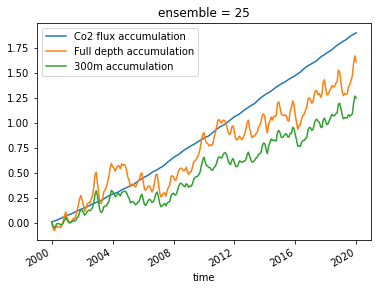

In [16]:
(co2.cumsum()/12).plot()
(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
plt.legend(['Co2 flux accumulation','Full depth accumulation','300m accumulation'])

In [17]:
# Ok Now lets sort out our transports

In [18]:
# N and S transport faces
#ty_transport=phys_eqpac[['ty_trans','ty_trans_gm']].sel(ensemble=25,time=slice('2000-01-01','2020-01-01'),lon=slice(120,300)).sel(lat_x=[-5,-3,3,5],method='nearest')
#ty_transport=ty_transport.rename({'lat_x':'lat'})
#ty_transport_loaded=ty_transport.load()

In [19]:
# E Boundary.
#tx_transport=phys_eqpac[['tx_trans','tx_trans_gm']].sel(ensemble=25,time=slice('2000-01-01','2020-01-01'),lat=slice(-5,5)).sel(lon_x=120,method='nearest')
#tx_transport=ty_transport.rename({'lon_x':'lon'})
#tx_transport_loaded=tx_transport.load()

In [46]:
#adic_concentrations=raw_carbon.adic-raw_carbon.dic
#adic_concentrations

In [21]:
# Nics method? IS STILL WRONG????

tv_gm=ty_transport_loaded.ty_trans_gm-ty_transport_loaded.ty_trans_gm.shift(st_ocean=-1)
tu_gm=tx_transport_loaded.tx_trans_gm-tx_transport_loaded.tx_trans_gm.shift(st_ocean=-1)
tv=ty_transport_loaded.ty_trans
tu=tx_transport_loaded.tx_trans

tv_canth_gm=(((tv_gm*adic_concentrations.interp(lat=ty_transport_loaded.lat))*12*60*60*24*365*1e6)/1e18)
tv_canth=(((tv*adic_concentrations.interp(lat=ty_transport_loaded.lat))*12*60*60*24*365*1e6)/1e18)

tu_canth_gm=(((tu_gm*adic_concentrations.sel(lon=120,method='nearest').interp(lat=tu.lat))*12*60*60*24*365*1e6)/1e18)
tu_canth=(((tu*adic_concentrations.sel(lon=120,method='nearest').interp(lat=tu.lat))*12*60*60*24*365*1e6)/1e18)


In [22]:
#adic_concentrations.sel(lon=120,method='nearest').interp(lat=tu.lat)
# We need to do the conversion AND rename the cols and possibly fix the lons to same coord system.
# * 1e6 *1e-15*12*1e-3 * 86400 *365
def fix_xuyu(dat):
    try:
        dat=dat.rename({'xu_ocean':'lon','yu_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xt_ocean':'lon','yu_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xt_ocean':'lon','yt_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xu_ocean':'lon','yt_ocean':'lat'})
        print('renamed')
    except:
        pass 
    try:
        dat=dat.rename({'xu_ocean':'lon'})
        print('renamed')
    except:
        pass 
    
    dat['time']=dat.time.astype('datetime64[M]')

    dat['lon']=dat['lon']+360
    #dat['lon_x']=dat['lon_x']+360
    return dat

In [47]:
# RICHARDS NUMBERS??? Overwrite so we can do a test. Need to do conversion though??
direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
tv=xr.open_dataset(direc+'trans_v.nc').ty_trans
tv_canth=xr.open_dataset(direc+'trans_aco2_v.nc').__xarray_dataarray_variable__
tv_canth_gm=xr.open_dataset(direc+'trans_aco2_v_gm.nc').__xarray_dataarray_variable__

tu=xr.open_dataset(direc+'trans_u.nc').tx_trans
tu_canth=xr.open_dataset(direc+'trans_aco2_u.nc').__xarray_dataarray_variable__
tu_canth_gm=xr.open_dataset(direc+'trans_aco2_u_gm.nc').__xarray_dataarray_variable__


tu=fix_xuyu(tu)
tu_canth=fix_xuyu(tu_canth).sel(xu_ocean=-239.5,method='nearest')#* 1e6 *1e-15*12*1e-3 * 86400 *365
tu_canth_gm=fix_xuyu(tu_canth_gm).sel(xu_ocean=-239.5,method='nearest')#* 1e6 *1e-15*12*1e-3 * 86400 *365

tv=fix_xuyu(tv)
tv_canth=fix_xuyu(tv_canth)#* 1e6 *1e-15*12*1e-3 * 86400 *365
tv_canth_gm=fix_xuyu(tv_canth_gm)#* 1e6 *1e-15*12*1e-3 * 86400 *365

renamed
renamed
renamed
renamed
renamed
renamed


In [48]:
N_face_tx=tv_canth.sel(lat=4.5,method='nearest')
N_face_tx_3=tv_canth.sel(lat=3,method='nearest')
N_face_tx_gm=tv_canth_gm.sel(lat=4.5,method='nearest')
N_face_tx_3_gm=tv_canth_gm.sel(lat=3,method='nearest')

S_face_tx=tv_canth.sel(lat=-4.5,method='nearest')
S_face_tx_3=tv_canth.sel(lat=-3,method='nearest')
S_face_tx_gm=tv_canth_gm.sel(lat=-4.5,method='nearest')
S_face_tx_3_gm=tv_canth_gm.sel(lat=-3,method='nearest')

S_face_tx_small=tv_canth.sel(lon=slice(145,300)).sel(lat=-5,method='nearest')
S_face_tx_gm_small=tv_canth_gm.sel(lon=slice(145,300)).sel(lat=-5,method='nearest')

E_face_tx=tu_canth
E_face_tx_gm=tu_canth_gm

In [49]:
ntx=-N_face_tx.sum(['lon','st_ocean'])
stx=S_face_tx.sum(['lon','st_ocean'])
stx_small=S_face_tx_small.sum(['lon','st_ocean'])

etx=E_face_tx.sum(['lat','st_ocean'])

ntx_gm=-N_face_tx_gm.sum(['lon','st_ocean'])
stx_gm=S_face_tx_gm.sum(['lon','st_ocean'])
stx_gm_small=S_face_tx_gm_small.sum(['lon','st_ocean'])

etx_gm=E_face_tx_gm.sum(['lat','st_ocean'])


itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm=(tu_canth_gm.sum(['st_ocean','lat'])+tv_canth_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

In [50]:
(tu_canth.sum(['st_ocean','lat']))* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491)>
array([ 0.03336841,  0.024264  , -0.04383466, -0.08188449, -0.10636162,
       -0.09225498, -0.10258461, -0.11845956, -0.11401801, -0.07470277,
       -0.02294027,  0.06583872,  0.04127726, -0.02833208, -0.09749288,
       -0.1118018 , -0.0818671 , -0.08825681, -0.10838437, -0.14582631,
       -0.14569857, -0.10086509, -0.02455498,  0.02291387,  0.09416372,
        0.00909237, -0.03194844, -0.0723325 , -0.09323863, -0.11675399,
       -0.10977745, -0.13072376, -0.11376101, -0.0486324 , -0.01367443,
        0.03902   ,  0.01823853, -0.06415682, -0.10376369, -0.14487579,
       -0.13634575, -0.12035255, -0.11182586, -0.16331778, -0.12650281,
       -0.10363416, -0.02811968,  0.03944757,  0.03493176, -0.08012528,
       -0.07365909, -0.1064002 , -0.14678938, -0.19712454, -0.22057248,
       -0.21660497, -0.2190104 , -0.16413127, -0.10828219, -0.03642336,
        0.01974571, -0.05149011, -0.09142188, -0.14602648, -0.10382933,
       -0.10003314, -0.16351913, -0.1976124 , -0.19043838, -0.12787576,
       -0.01780953, -0.0029138 ,  0.01537998, -0.07006772, -0.1551526 ,
       -0.18527654, -0.11313417, -0.08856373, -0.14295719, -0.18047082,
       -0.16193635, -0.09983636, -0.00953309,  0.04743009, -0.03250278,
       -0.00276042, -0.04674461, -0.10863161, -0.12096107, -0.13952508,
       -0.13615442, -0.16715011, -0.14668034, -0.07636336, -0.08350459,
        0.0574031 ,  0.08742288, -0.01609728, -0.03704311, -0.0835491 ,
...
        0.11662825, -0.01565254, -0.13178156, -0.22293213, -0.24525333,
       -0.26545558, -0.26677534, -0.37233644, -0.42109272, -0.35683072,
       -0.2824932 , -0.06917766,  0.11241397,  0.0609057 , -0.15422782,
       -0.19204606, -0.17449704, -0.20281456, -0.20032382, -0.23196499,
       -0.24777391, -0.24619666, -0.13651561, -0.07146285,  0.06931066,
        0.07152589, -0.0478248 , -0.14575462, -0.11312978, -0.17288338,
       -0.14322019, -0.16327326, -0.21197731, -0.19852657, -0.08152415,
       -0.01688655, -0.0309784 , -0.03068144, -0.11200329, -0.13665476,
       -0.15311988, -0.21841023, -0.22376642, -0.29137182, -0.29085242,
       -0.28659473, -0.27662015, -0.00786727,  0.01814448, -0.04150472,
       -0.06964166, -0.19682009, -0.16576888, -0.23803377, -0.2317184 ,
       -0.24765806, -0.41921966, -0.38427957, -0.25781188, -0.1786337 ,
       -0.06479393, -0.08794446, -0.10153975, -0.26415392, -0.22370993,
       -0.26249727, -0.22336578, -0.28135419, -0.33142809, -0.32506849,
       -0.09202825, -0.01291173,  0.03653928, -0.02007365, -0.10508745,
       -0.18198073, -0.18063507, -0.24333445, -0.20314139, -0.28370019,
       -0.39602662, -0.38330542, -0.27798957, -0.03452163, -0.03470918,
       -0.07353531, -0.17327315, -0.19297807, -0.25452865, -0.20601172,
       -0.21426861, -0.3454483 , -0.40428744, -0.38424355, -0.28559429,
       -0.00637972])
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-11-01
    lon       float64 121.0
    xu_ocean  float64 -239.0

In [51]:
(tu_canth.sum(['st_ocean','lat'])).mean()* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(-0.13426464)
Coordinates:
    ensemble  int32 25
    lon       float64 121.0
    xu_ocean  float64 -239.0

In [52]:
(tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values

array(-103.673355, dtype=float32)

In [53]:
(tv_canth.sel(lon=slice(100,320)))#.sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491, st_ocean: 50,
                                                   lat: 42, lon: 180)>
[185598000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 296.5 297.5 298.5 299.5
    yt_ocean  (lat) float64 ...
  * lat       (lat) float64 -6.667 -6.333 -6.0 -5.667 ... 6.0 6.333 6.667 7.0

In [54]:
(tv_canth.sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values

array(417.5062, dtype=float32)

In [55]:
etx.mean().values

array(-354.792, dtype=float32)

In [56]:
(ntx.mean()* 1e6 *1e-15*12*1e-3 * 86400 *365).values

array(-0.13236278)

In [57]:
ntx.mean().values

array(-349.76636, dtype=float32)

In [58]:
(stx.mean()* 1e6 *1e-15*12*1e-3 * 86400 *365).values

array(0.16910767)

In [59]:
tu_canth.sum(['st_ocean','lat']).mean().values

array(-354.792, dtype=float32)

In [60]:
tu_canth

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491, st_ocean: 50,
                                                   lat: 42)>
array([[[ 4.804118,  4.286681, ...,  0.02457 ,  0.014126],
        [ 4.295589,  3.781858, ...,  0.119282,  0.107722],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[ 4.654067,  4.142298, ..., -1.266082, -1.41358 ],
        [ 4.043026,  3.531069, ..., -0.91597 , -1.021515],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[-5.219748, -5.737843, ..., -0.085822,  0.541861],
        [-4.098223, -4.463827, ..., -0.333252,  0.232049],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-3.080599, -3.184924, ...,  4.823994,  4.921871],
        [-2.386547, -2.420836, ...,  3.828129,  3.95574 ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-11-01
  * lat       (lat) float64 -6.833 -6.5 -6.166 -5.834 ... 5.834 6.166 6.5 6.833
    lon       float64 121.0
    xu_ocean  float64 -239.0

In [61]:
ntx+ntx_gm+stx+stx_gm+etx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491)>
array([-1.45690234e+03, -1.04772229e+03, -2.15491608e+02,  1.17682202e+03,
        1.40053040e+02, -7.69832275e+02, -8.78994751e+00,  3.34612823e+02,
       -2.89021057e+02,  8.73367188e+02,  8.25755066e+02,  2.21402374e+02,
       -8.89170654e+02, -7.69088867e+02, -2.38368683e+01,  1.12948926e+03,
       -3.49158630e+02, -5.97853027e+02, -8.48285522e+02, -4.29820953e+02,
        9.39789490e+02,  6.03903076e+02,  1.38110571e+03,  8.48707047e+01,
       -3.83882141e+00, -1.22676660e+03, -1.09814941e+02,  5.68744263e+02,
        5.58658600e+01, -6.27925476e+02, -1.16469800e+03,  2.17586487e+02,
        4.33950836e+02,  1.02574341e+03,  3.74420380e+02, -8.57253845e+02,
       -1.12141638e+03, -1.40318909e+03,  9.34390259e+01,  8.35427124e+02,
       -4.05196930e+02, -2.31601562e+03,  1.31641449e+02,  4.68448181e+01,
        5.76873291e+02,  2.50954926e+02,  1.00287122e+03, -5.10249207e+02,
       -1.39470535e+02, -2.50940720e+02,  3.18056458e+02,  3.85418671e+02,
        6.53834961e+02, -5.61363708e+02, -9.50079346e+02, -3.70857300e+02,
        2.75880127e+02,  1.93285065e+02,  7.47541260e+02,  5.41679153e+01,
       -8.95239792e+01, -5.61070007e+02,  2.35386627e+02, -7.44631958e+00,
       -1.38606140e+02, -6.61063660e+02, -5.08314880e+02, -5.63342834e+02,
        8.25481628e+02,  4.80205170e+02,  8.63864990e+02,  2.10972931e+02,
       -6.31547791e+02, -3.30737427e+02, -4.16883789e+02,  8.92406311e+02,
        4.01357300e+02, -1.52357483e+02, -4.82862366e+02, -8.04924927e+02,
...
       -9.73469482e+02, -1.67201929e+03, -2.34007446e+03, -1.19271912e+03,
       -1.90269928e+02,  8.85498901e+02,  1.37272498e+03, -5.68553833e+02,
       -2.83436035e+03, -1.44641077e+03,  7.82545776e+01,  1.26407776e+01,
       -3.78860199e+02, -1.86043823e+03, -2.18846729e+03, -1.56577051e+03,
       -1.89345679e+03,  1.52592676e+03,  4.40567200e+02, -3.04588525e+03,
       -3.06900317e+03, -4.57887646e+03, -3.49707581e+02, -1.58572278e+03,
        2.17841431e+02, -2.87076141e+02, -7.27827026e+02, -1.21180737e+03,
       -1.27730042e+02,  1.24682837e+03,  2.23609961e+03, -3.87612000e+02,
       -2.36405591e+03, -1.78867163e+03,  1.33621411e+03,  1.32976758e+03,
       -1.00126343e+02, -1.60443091e+03, -1.75400000e+03, -2.73367847e+03,
       -2.04201978e+03,  2.55355981e+03,  9.42104980e+02, -1.57622864e+02,
       -1.44850964e+03, -1.63073059e+02,  9.19075134e+02,  9.52706482e+02,
       -2.00982483e+02, -1.44903027e+03, -1.67645483e+03, -1.08410791e+03,
       -5.10244049e+02,  2.00872168e+03,  8.00057068e+02, -2.32478271e+03,
       -3.40022583e+03, -3.67902539e+03, -4.50664246e+02,  4.62512268e+02,
       -5.86695190e+02, -2.07901367e+03, -1.73697119e+03, -1.63413086e+03,
        4.01651611e+01,  1.21045459e+03,  1.43134814e+03, -1.12958023e+02,
       -2.93226074e+03, -3.99343457e+03,  1.76434631e+01,  8.06464294e+02,
        6.40406921e+02, -1.50169482e+03, -2.18988135e+03, -1.72743762e+03,
        3.28332520e+00,  1.02534009e+03,  1.84520166e+03], dtype=float32)
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-11-01
    yt_ocean  float64 ...
    lat       float64 -4.333
    lon       float64 121.0
    xu_ocean  float64 -239.0

In [62]:
co2

<xarray.DataArray (time: 241)>
array([0.06898808, 0.06539813, 0.05466319, 0.0439824 , 0.05088791,
       0.07118167, 0.07639796, 0.07333538, 0.06897366, 0.06341061,
       0.06129609, 0.07011474, 0.07280739, 0.06142503, 0.05617703,
       0.05065694, 0.06023027, 0.07818391, 0.08964024, 0.07667503,
       0.07474427, 0.06909093, 0.06414478, 0.07062569, 0.06190165,
       0.06669872, 0.06985851, 0.04687421, 0.06312327, 0.07141414,
       0.08983583, 0.08800813, 0.06386368, 0.05853938, 0.05441389,
       0.07017681, 0.0658676 , 0.08101919, 0.05897604, 0.05886493,
       0.0793267 , 0.10187872, 0.10825165, 0.10377809, 0.08617223,
       0.08053651, 0.06510948, 0.06657964, 0.05879309, 0.06344444,
       0.0496972 , 0.03866162, 0.06511314, 0.0802278 , 0.10755158,
       0.09643707, 0.07659505, 0.07042006, 0.06298837, 0.07246474,
       0.0756113 , 0.0651847 , 0.06633339, 0.05203964, 0.06755222,
       0.10254062, 0.116253  , 0.13439725, 0.10355781, 0.10139553,
       0.0925435 , 0.09559906, 0.08930696, 0.09486613, 0.07170689,
       0.0702436 , 0.08401251, 0.10755458, 0.12258095, 0.11436717,
       0.09193107, 0.06962803, 0.07037913, 0.08199009, 0.104939  ,
       0.10196714, 0.08397196, 0.07180767, 0.09634656, 0.1321154 ,
       0.14859311, 0.13671675, 0.12574123, 0.11841037, 0.11776584,
       0.1151032 , 0.12215509, 0.10097784, 0.09151212, 0.08039221,
...
       0.0967178 , 0.08167315, 0.06908221, 0.09225837, 0.1186513 ,
       0.12658617, 0.13188007, 0.11565464, 0.10150294, 0.10196505,
       0.10277344, 0.10480314, 0.09246664, 0.09004214, 0.07572183,
       0.10332743, 0.13756596, 0.14582098, 0.15421592, 0.13793531,
       0.13023016, 0.11701921, 0.10475668, 0.097374  , 0.10835507,
       0.08071322, 0.06698947, 0.09801792, 0.11870986, 0.12184487,
       0.12731917, 0.1099161 , 0.10772246, 0.09220985, 0.09038188,
       0.10573686, 0.10390536, 0.07991898, 0.06602796, 0.0823043 ,
       0.10247627, 0.11350565, 0.10452386, 0.10398476, 0.08146634,
       0.06651068, 0.09091894, 0.10964569, 0.12128948, 0.08319797,
       0.09715194, 0.10700083, 0.13278084, 0.14819846, 0.14474964,
       0.12351224, 0.11274383, 0.09169412, 0.08772358, 0.09900893,
       0.09334153, 0.07354351, 0.06826694, 0.09114278, 0.12026993,
       0.13512348, 0.14224006, 0.13574757, 0.09808641, 0.10060287,
       0.11048544, 0.10895232, 0.10109466, 0.08308238, 0.08096399,
       0.0968705 , 0.12732252, 0.13510707, 0.13780421, 0.12245735,
       0.11438654, 0.09001762, 0.10486674, 0.10957231, 0.11134531,
       0.09479345, 0.07099828, 0.09638672, 0.1331947 , 0.11126887,
       0.12233487, 0.10850497, 0.09331861, 0.07471775, 0.06585852,
       0.11140082], dtype=float32)
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01

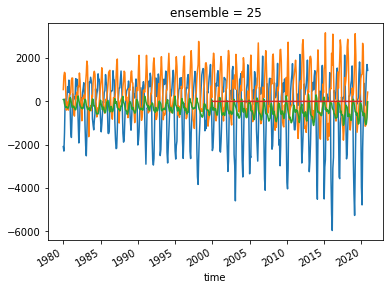

In [63]:
(ntx+ntx_gm).plot()
(stx+stx_gm).plot()
(etx+etx_gm).plot()
co2.plot()

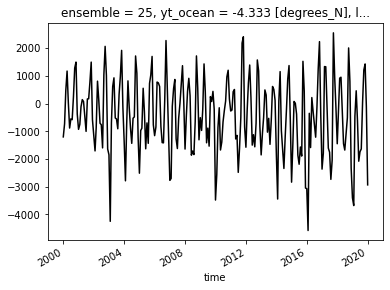

In [64]:
((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2)).plot(c='k')

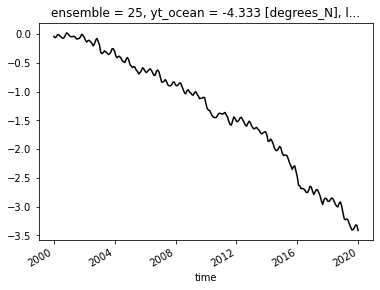

In [65]:
(((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2)* 1e6 *1e-18*12*86400 *365).cumsum()/12).plot(c='k')

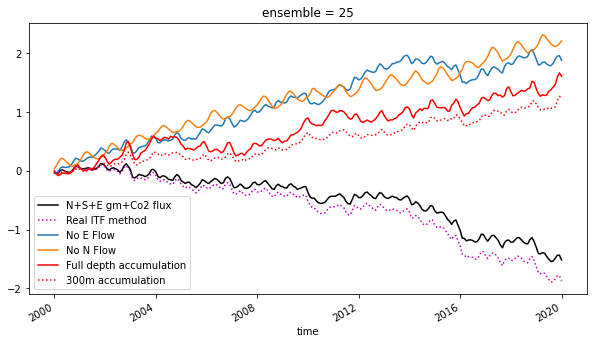

In [66]:
# \ ACCUMULATION FIGURE #((ntx+stx+etx).cumsum()/12).plot() #* 1e6 *1e-18*12*86400 *365
plt.figure(figsize=(10,5))
(((((ntx+ntx_gm+stx+stx_gm+etx+etx_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365)+co2)).cumsum()/12).plot(c='k')
#((-(ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2)).cumsum()/12).plot(c='k',linestyle=':')
((((ntx+ntx_gm+stx_small+stx_gm_small+itf_canth+itf_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365)+co2).cumsum()/12).plot(linestyle=':',c='m')

(((((ntx+ntx_gm+stx+stx_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365)+co2)).cumsum()/12).plot()
((((stx+stx_gm+etx+etx_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365)+co2).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

#((ntx+stx+etx+co2).cumsum()/12).plot
#((ntx+stx+etx+co2).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r')
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r',linestyle=':')
plt.legend(['N+S+E gm+Co2 flux','Real ITF method','No E Flow','No N Flow','Full depth accumulation','300m accumulation'])

In [43]:
#trans_aco2[:,:,0,:]#.sum(axis=(1,2))#.compute()

In [67]:
# RICHARDS NUMBERS??? Overwrite so we can do a test. Need to do conversion though??
direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
tv=xr.open_dataset(direc+'trans_v.nc').ty_trans
trans_aco2=xr.open_dataset(direc+'trans_aco2_v.nc').__xarray_dataarray_variable__
trans_aco2_gm=xr.open_dataset(direc+'trans_aco2_v_gm.nc').__xarray_dataarray_variable__

#tu=xr.open_dataset(direc+'trans_u.nc').tx_trans
#tu_canth=xr.open_dataset(direc+'trans_aco2_u.nc').__xarray_dataarray_variable__
#tu_canth_gm=xr.open_dataset(direc+'trans_aco2_u_gm.nc').__xarray_dataarray_variable__





trans_s_gm=trans_aco2_gm[:,:,0,:].sum(axis=(1,2)).compute()
trans_n_gm=trans_aco2_gm[:,:,28,:].sum(axis=(1,2)).compute()
trans_s=trans_aco2[:,:,0,:].sum(axis=(1,2)).compute()
trans_n=trans_aco2[:,:,28,:].sum(axis=(1,2)).compute()

mtrans_s=tv[:,:,0,:].sum(axis=(1,2)).compute()
mtrans_n=tv[:,:,28,:].sum(axis=(1,2)).compute()

trans_s_gm_300=trans_aco2_gm[:,0:24,0,:].sum(axis=(1,2)).compute()
trans_n_gm_300=trans_aco2_gm[:,0:24,28,:].sum(axis=(1,2)).compute()
trans_s_300=trans_aco2[:,0:24,0,:].sum(axis=(1,2)).compute()
trans_n_300=trans_aco2[:,0:24,28,:].sum(axis=(1,2)).compute()

mtrans_s_300=tv[:,0:24,0,:].sum(axis=(1,2)).compute()
mtrans_n_300=tv[:,0:24,28,:].sum(axis=(1,2)).compute()


print(trans_s_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_s_gm_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_gm_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

print(mtrans_s_300.mean(axis=0).values )
print(mtrans_n_300.mean(axis=0).values )
print('\n')
print(trans_s.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_s_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

print(mtrans_s.mean(axis=0).values )
print(mtrans_n.mean(axis=0).values )

0.01557030186694336
-0.006650446089111329
0.18992300770898438
-0.004195282161621095
-0.027132643
10.070272


0.1281516636796875
-0.0044050464140625
0.17962946790820314
-0.001850140852020264
9.830371
6.3304596


In [68]:
trans_aco2[:,:,28,:]

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491, st_ocean: 50,
                                                   xt_ocean: 180)>
[4419000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) object 1980-01-16 12:00:00 ... 2020-11-16 00:00:00
  * xt_ocean  (xt_ocean) float64 -239.5 -238.5 -237.5 ... -62.5 -61.5 -60.5
    yt_ocean  float64 ...
    yu_ocean  float64 2.667

In [69]:
tv_canth

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491, st_ocean: 50,
                                                   lat: 42, lon: 180)>
[185598000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 296.5 297.5 298.5 299.5
    yt_ocean  (lat) float64 -6.667 -6.333 -6.0 -5.667 ... 6.0 6.333 6.667 7.0
  * lat       (lat) float64 -6.667 -6.333 -6.0 -5.667 ... 6.0 6.333 6.667 7.0

In [70]:
print((tv_canth.sel(lat=-4.7,method='nearest').sum(['lon','st_ocean'])* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)
print((tv_canth.sel(lat=4.7,method='nearest').sum(['lon','st_ocean'])*1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)

print(((tv_canth+tv_canth_gm).sel(lat=-4.7,method='nearest').sum(['lon','st_ocean'])* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)
print(((tv_canth+tv_canth_gm).sel(lat=4.7,method='nearest').sum(['lon','st_ocean'])*1e6 *1e-15*12*1e-3 * 86400 *365).mean().values)

0.16368028074098356
0.13236279564909914
0.1596419955738898
0.13267883214931614


In [71]:
print(tv_canth.sel(lat=-4.7,method='nearest').sum(['lon','st_ocean']).mean().values)
print(tv_canth.sel(lat=4.7,method='nearest').sum(['lon','st_ocean']).mean().values)

432.52228
349.76636


In [72]:
print(trans_aco2[:,:,0,:].sum(axis=(1,2)).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)
print(tv_canth.sel(lat=-4.7,method='nearest').sum(['lon','st_ocean']).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)

print(trans_aco2[:,:,28,:].sum(axis=(1,2)).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)
print(tv_canth.sel(lat=4.7,method='nearest').sum(['lon','st_ocean']).mean().values* 1e6 *1e-15*12*1e-3 * 86400 *365)

0.1281516636796875
0.16368027064453125
0.17962946790820314
0.13236278217187503


In [73]:
tv_canth.sel(lat=4.5,method='nearest').sum(['lon','st_ocean']).mean()* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.13236278)
Coordinates:
    ensemble  int32 25
    yt_ocean  float64 4.667
    lat       float64 4.667

In [74]:
tv_canth.sel(lat=-4.5,method='nearest').sum(['lon','st_ocean']).mean()* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.16910767)
Coordinates:
    ensemble  int32 25
    yt_ocean  float64 -4.333
    lat       float64 -4.333

In [75]:
trans_aco2.sel(yu_ocean=4.5,method='nearest').sum(['xt_ocean','st_ocean']).mean()* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.13236278)
Coordinates:
    ensemble  int32 25
    yt_ocean  float64 ...
    yu_ocean  float64 4.667

In [76]:
trans_aco2.sel(yu_ocean=-4.5,method='nearest').sum(['xt_ocean','st_ocean']).mean()* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.16910767)
Coordinates:
    ensemble  int32 25
    yt_ocean  float64 ...
    yu_ocean  float64 -4.333

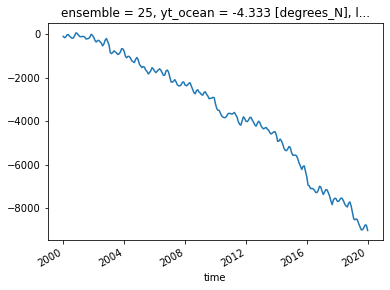

In [77]:
((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2).cumsum()/12).plot()

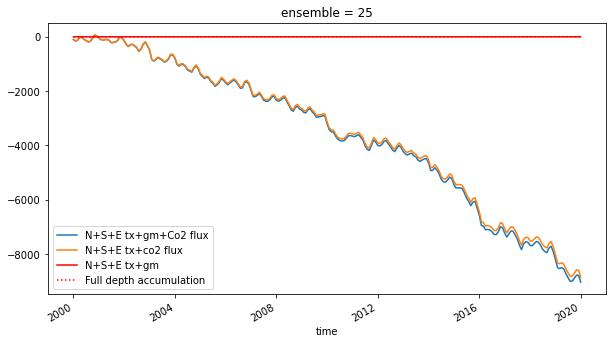

In [78]:
# ACCUMULATION FIGURE #((ntx+stx+etx).cumsum()/12).plot()
plt.figure(figsize=(10,5))
((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2).cumsum()/12).plot()
((ntx+stx+etx+co2).cumsum()/12).plot()
#((ntx+ntx_gm+stx+stx_gm+etx+etx_gm).cumsum()/12).plot()

#((ntx+stx+etx+co2).cumsum()/12).plot()


(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r')
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r',linestyle=':')
plt.legend(['N+S+E tx+gm+Co2 flux','N+S+E tx+co2 flux','N+S+E tx+gm','Full depth accumulation','300m accumulation'])

In [79]:
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).mean()/20

<xarray.DataArray ()>
array(0.02591431)
Coordinates:
    ensemble  int32 25

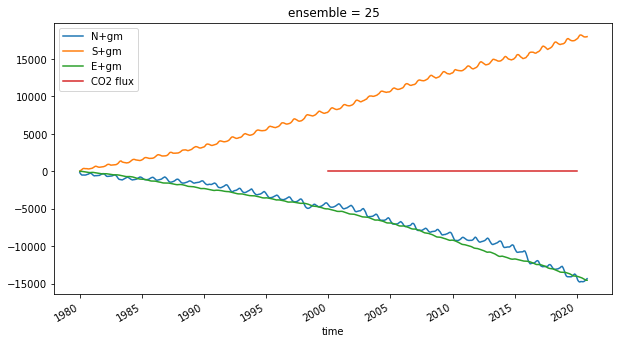

In [80]:
plt.figure(figsize=(10,5))
((ntx+ntx_gm).cumsum()/12).plot()
((stx+stx_gm).cumsum()/12).plot()
((etx+etx_gm).cumsum()/12).plot()
(co2.cumsum()/12).plot()
plt.legend(['N+gm','S+gm','E+gm','CO2 flux'])

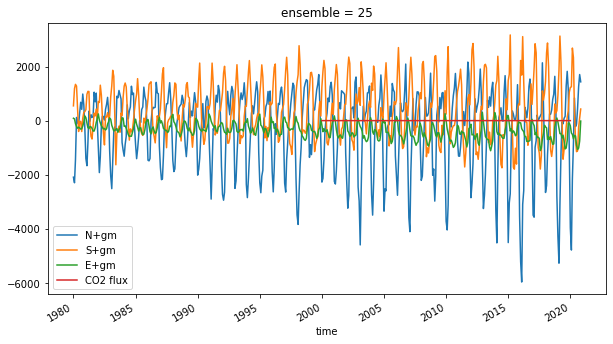

In [81]:
plt.figure(figsize=(10,5))
((ntx+ntx_gm)).plot()
((stx+stx_gm)).plot()
((etx+etx_gm)).plot()
(co2).plot()
plt.legend(['N+gm','S+gm','E+gm','CO2 flux'])

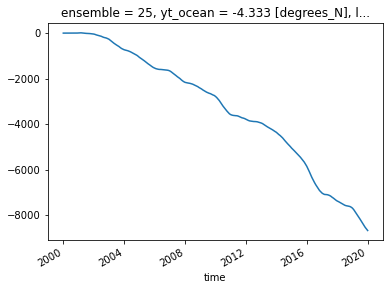

In [82]:
((ntx+ntx_gm+stx+stx_gm+etx+etx_gm+co2).rolling(time=12).mean().cumsum()/12).plot()

In [83]:
# PREPARE FOR PLOTTING

In [84]:
# LOAD ENSO

#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon


def add_enso_colours(ax):
    #Put in the ENSO box regions
    #ep_events and cp events
    import matplotlib.patches as patches
    ensofps=['../processed_data/indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv']
    ensofps=['../processed_data//indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv','../processed_data//indexes/cold_cp_events.csv']
    ensofps=['../processed_data//indexes/ep_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv']
    for whichenso,fp in enumerate(ensofps):
        events=pd.read_csv(fp)
        for ev in events.iterrows():
            endm=np.datetime64(ev[1].end).astype('datetime64[M]')
            endm1=endm-np.timedelta64(1,'M')
            endm2=endm+np.timedelta64(1,'M')
            start=np.datetime64(ev[1].start).astype('datetime64[M]')
          
            if start==endm1: #We don't want to plot events that last for only a month
                pass    
            #elif start==endm2-np.timedelta64(1,'M'): #There was some weirdness with the 2015 event not being continuous, and this fixes it..,
            #    pass
            else:
                if whichenso==0:
                    #if el nino
                    patchcol='darkred'#'firebrick'
                elif whichenso==1:
                    #if la nina
                    patchcol='deepskyblue'
                elif whichenso==2:
                    patchcol='darkorange'
                elif whichenso==3:
                    patchcol='navy'
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
    return True

In [85]:
# Need to trim or shorten
def linear_trend(ax,x,y):#,xlab,ylab,diagonal_line=1,printer=1,plot=1,logspace=0,color=np.ndarray(0),zx=np.ndarray(0),zy=np.ndarray(0),trendline=1):
    """"
    Designed for chlorophyll trends <1mg/m3 
    
    Given an x and y (same size)
    + Title, X Label, Y Label
    
    if Z, will plot 
    Optional: Diagonal_line=0, default on.
    Optional: Printer=0, default on
    
    Returns linear statistics. 
    """
    
    x1=np.ravel(x)
    y=np.ravel(y)
    mask=~np.isnan(x1)
    x=x[mask]
    y=y[mask]
    x2=x1.astype('datetime64[D]')
    slope, intercept, r_value, p_value, std_err = linregress(pd.to_numeric(x2),y)
    #if plot==0:
    #     return slope, intercept, r_value, p_value, std_err 
    
    mn=min(pd.to_numeric(x2))
    mx=max(pd.to_numeric(x2))
    x2=np.linspace(mn,mx,len(x2))
    y1=slope*pd.to_numeric(x2)+intercept
    plt.plot(x,y1,'r:',linewidth=2)  
     
    return slope, intercept, r_value, p_value

In [86]:
# Load Regions? 

region_mask=xr.open_dataset('new_calculations/region_mask_new.nc').sortby('lat') #region_mask_may12
region_mask['st_ocean']=region_mask['st_ocean']*-1
region_mask=region_mask.load()
region_mask#.close()#mask['st_ocean']=mask.st_ocean*-1 # mask will need a bit of fixing (where =1)

<xarray.Dataset>
Dimensions:            (lon: 170, st_ocean: 30, lat: 7, time: 731)
Coordinates:
  * lon                (lon) float64 120.5 121.5 122.5 ... 287.5 288.5 289.5
  * st_ocean           (st_ocean) float64 5.0 15.0 25.0 ... 665.4 812.8 969.1
  * lat                (lat) float64 -8.833 -4.833 -2.833 ... 3.167 5.167 9.167
  * time               (time) datetime64[ns] 1960-01-01 ... 2020-11-01
    ensemble           int32 25
Data variables:
    south_subsurface   (st_ocean, lon, time, lat) float64 nan nan ... 0.0 0.0
    south_surface      (st_ocean, lon, time, lat) float64 nan nan ... 0.0 0.0
    south_wbc          (st_ocean, lon, time, lat) float64 nan nan ... nan nan
    shallow_south_wbc  (st_ocean, lon, time, lat) float64 nan nan ... nan nan
    above_isopycnal    (st_ocean, lon, time, lat) bool True True ... False False
    north_subsurface   (st_ocean, lon, time, lat) float64 nan nan ... 0.0 0.0
    north_surface      (st_ocean, lon, time, lat) float64 nan nan ... 0.0 0.0
    north_wbc          (st_ocean, lon, time, lat) float64 1.0 1.0 ... nan nan
    shallow_north_wbc  (st_ocean, lon, time, lat) float64 1.0 1.0 ... nan nan
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [87]:
# CALCULATE TABLE
# For Table also need CO2 flux and Accumulation rates / yr

In [ ]:
# TABLE?
ev=[None,neutral_events,ep_events,cp_events,nina_events]
evName=['Alltime','Neutral','EP','CP','La Nina']

#method='std' # or mean
region_mask['south_wbc_subsurface']=xr.concat([region_mask.south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_wbc_subsurface']=xr.concat([region_mask.north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['south_shallowwbc_subsurface']=xr.concat([region_mask.shallow_south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_shallowwbc_subsurface']=xr.concat([region_mask.shallow_north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()

masksN=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.shallow_north_wbc,region_mask.north_wbc_subsurface,region_mask.north_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
masksS=[region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.shallow_south_wbc,region_mask.south_wbc_subsurface,region_mask.south_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
direction=[4.5,-4.5]
dir_names=['5N','5S']
mask_names=['Subsurface','Surface','WBC','ShallowWBC','WBC+Interior','ShallowWBC+Interior','Above Isotherm','Full Depth']#'positive','negative']

# CHECK WHICH VARS INPUT!
varz_mean=[ty_transport_loaded.ty_trans,
           tv_canth* 1e6 *1e-15*12*1e-3 * 86400 *365,
           (tv_canth+tv_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365]

varz=varz_mean
method='mean' #'total #Syn #std
var_names=['Meridional Transport','AnthC transport','AnthC+GM transport']#,'C transport','adic','adic_accumulation']

In [ ]:
for method in ['std','mean']:
    df_holder=[]
    for iENSO,enso_dates in enumerate(ev):
        enso_name=evName[iENSO]
        for var_i,data_type in enumerate(varz):

            data_type=data_type.sel(time=slice('2000','2020'))
            if enso_dates is not None:
                data_type=data_type.sel(time=enso_dates)
                
                
            df_row_holder=[]
            for i,NS in enumerate(direction):
                if i==0: # North
                    mask_holder=masksN
                    #data_type=data_type*-1
                elif i==1: # South
                    mask_holder=masksS
                    data_type=data_type.sel(lon=slice(145,300)) # REMOVE ITF FROM S FACE
                    
                    
                for depth_i,depth_region in enumerate(mask_holder):
                    var_name=var_names[var_i]
                    depth_name=mask_names[depth_i]
                    direction_name = dir_names[i]


                    d=None
                    if depth_name=='Full Depth':
                        if method=='mean':
                            d=data_type.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon']).mean(dim='time').values
                        elif method=='std':
                            d=data_type.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon']).std(dim='time').values
                        elif method=='sum':
                            d=data_type.sel(lat=NS,method='nearest').sum(dim='time').sum().values
                    elif depth_name=='positive': 
                        d=data_type.sel(lat=NS,method='nearest')
                        if method=='mean':
                            d=d.where(d>=0).sum(dim=['st_ocean','lon']).mean(dim='time').values
                        elif method=='std':
                            d=d.where(d>=0).sum(dim=['st_ocean','lon']).std(dim='time').values
                        elif method=='sum':
                            d=d.where(d>=0).sum(dim='time').sum().values

                    elif depth_name=='negative':
                        d=data_type.sel(lat=NS,method='nearest')
                        if method=='mean':  
                            d=d.where(d<0).sum(dim=['st_ocean','lon']).mean(dim='time').values  
                        elif method=='std':  
                            d=d.where(d<0).sum(dim=['st_ocean','lon']).std(dim='time').values  
                        elif method=='sum':  
                            d=d.where(d<0).sum(dim='time').sum().values  

                    if mask_holder[depth_i] is not None:
                        depth_reg=mask_holder[depth_i].sel(lat=NS,method='nearest')                           
                        
                        if method=='mean': 
                            d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim=['st_ocean','lon']).mean(dim='time').values
                            
                            #if depth_name=='WBC+Interior':
                            #    brekkkknow
                        elif method=='std': 
                            d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim=['st_ocean','lon']).std(dim='time').values
                        elif method=='sum': 
                            d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim='time').sum().values

                    if i==0: #North
                        d*=-1
                    #print(f'{var_name}{direction_name} {depth_name} {enso_name} {method} {d}')

                    df_row_holder.append(pd.DataFrame(data={var_name:d},index=pd.MultiIndex.from_tuples([(depth_name,direction_name,enso_name)])))

                    #pd.DataFrame({title:name={depth_name} 

                df_holder.append(pd.concat(df_row_holder))


    table1=pd.concat(df_holder,axis=0,join='outer')#.dropna(thresh=10,axis=1)
    table1=table1.groupby(level=[0,1,2]).mean()
    table1.to_csv(f'transport_numbers_{method}_july12.csv')
table1

### print(((ntx+ntx_gm).mean().values))
print((stx+stx_gm).mean().values)



In [ ]:
table=pd.read_csv('transport_numbers_mean_july12.csv',index_col=[0,1,2])
tablestd=pd.read_csv('transport_numbers_std_july12.csv',index_col=[0,1,2])
table.reset_index().query("level_2=='Alltime'")#['AnthC+GM transport']

In [ ]:
tablestd.reset_index().query("level_2=='Alltime'")

In [ ]:
tablestd.reset_index().query("level_2=='Alltime'").groupby('level_0').sum().round(3)

In [ ]:
table.reset_index().query("level_2=='Alltime'").groupby('level_0').sum().round(3)

In [ ]:
tv#.sel(lon=slice(120,145)).sel(lat=-5,method='nearest')#.sum(['st_ocean','lon'])

In [ ]:
tv['time']=tv.time.astype('datetime64[M]')

In [ ]:
tv

In [ ]:
canth_in_box=((anth_c_area.sel(time=slice('2000','2020'),lat=slice(-5,5)).sum(['st_ocean','lat','lon'])*12)/1e18)#.mean()
canth_in_box_2000=canth_in_box-canth_in_box.values[0]
canth_300m=(((anth_c_area.sel(time=slice('2000','2020'))-anth_c_area.sel(time=slice('2000','2020')).values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18)
             

#itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

#itf=(tu.sum(['st_ocean','lat'])+tv.sel(xt_ocean=slice(120,145)).sel(yu_ocean=-5,method='nearest').sum(['st_ocean','xt_ocean']))
itf=(tu.sum(['st_ocean','lat'])+tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))


itf_canth_gm=(tu_canth_gm.sum(['st_ocean','lat'])+tv_canth_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_gm=(tu_gm.sum(['st_ocean','lat'])+tv_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

In [ ]:
print(f'CO2 flux Mean: {co2.mean().round(3).values}')
print(f'CO2 flux std: {co2.std().round(3).values}')
print(f'ITF Canth Mean: {(itf_canth* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().round(3).values}')
print(f'ITF Canth STD: {(itf_canth* 1e6 *1e-15*12*1e-3 * 86400 *365).std().round(3).values}')
print(f'ITF Canth GM Mean: {((itf_canth+itf_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().round(3).values}')
print(f'ITF Canth GM STD: {((itf_canth+itf_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365).std().round(3).values}')


print(f'ITF SV Mean: {(itf* 1e6 *1e-15*12*1e-3 * 86400 *365).mean().round(3).values}')
print(f'ITF SV STD: {(itf* 1e6 *1e-15*12*1e-3 * 86400 *365).std().round(3).values}')

print(f'Canth Accumulation Mean: {(canth_in_box_2000.mean()/20).round(3).values}')
print(f'Canth Accumulation STD: {(canth_in_box_2000.std()/20).round(3).values}')

print(f'Canth 300 Accumulation Mean: {(canth_300m.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation STD: {(canth_300m.std()/20).round(3).values}')

In [ ]:
# CHECK ENSO CHANGES

plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['Subsurface','WBC','Surface']]['Meridional Transport'].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('Transport (Sv)')
plt.xticks(rotation=360)
plt.grid()
ax=plt.subplot(212)
table.loc[['Subsurface','WBC','Surface']]['AnthC transport'].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('AnthC Transport PgC/ Yr')
plt.xticks(rotation=360)

plt.tight_layout()

In [ ]:
#tv,tv_gm, tv_canth,tv_canth_gm

In [ ]:
# FIGURE PLOT? NEED UPDATING!!!!

plt.figure(figsize=(14,14),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(5,2,1)
cplot=(cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
plt.ylim([-800,0])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,2)
cplot=((-cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x}))).sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-500,0])
plt.ylim([-800,0])
plt.title('b) Meridional transport 5°N')

                
plt.subplot(5,2,3)

(anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional C$_{anth}$ transport 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylim([-800,0])
plt.ylabel('Depth (m)')

plt.subplot(5,2,4)

(-anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional C$_{anth}$ transport 5°N')
plt.xlim([120,280])
#plt.ylim([-500,0])
plt.ylim([-800,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,5)
(adic_plot.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))#10000,1000)))


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('e) C$_{anth}$ 5°S')
plt.xlim([140,280])
plt.ylim([-800,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,6)
(adic_plot.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))##,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.ylim([-800,0])
plt.title('f) C$_{anth}$ 5°N')





dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=7,sb1=5,sb2=2,title='g) Surface meridional velocity (<50m)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')

# Subsurface
dat2=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Interior meridional velocity (>50m and <1026.3)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')



#dat1=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ inventory (<50m)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))

# Subsurface
#dat2=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Subsurface C$_{anth}$ inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)

dat1=(adic_plot).sel(st_ocean=slice(0,-50)).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ mean concentration (<50m)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))


dat2=(adic_plot).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Interior C$_{anth}$ mean concentration (>50m and <1026.3)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)



#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [ ]:
# Replicate Zeller Anomalies
tv

In [ ]:
region_mask

In [ ]:
#tv, tv_gm, tv_canth, tv_canth_gm, same as us. 

ymertrans_wbcS=tv.sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN=-tv.sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


ymertrans_wbcS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


ymertrans_wbc=ymertrans_wbcN+ymertrans_wbcS
ymertrans_surface=ymertrans_surfaceN+ymertrans_surfaceS
ymertrans_subsurface=ymertrans_subsurfaceN+ymertrans_subsurfaceS

ymertrans_S=tv.sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
ymertrans_N=-tv.sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()

#(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
#(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
#(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
interior=ymertrans_wbcS+ymertrans_wbcN+ymertrans_subsurfaceN+ymertrans_subsurfaceS
surface=ymertrans_surfaceN+ymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN


#anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

#anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=tu_canth#(((anth_dic_area_u_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx=tv_canth#(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx_gm=tv_canth_gm#(((anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6


anthymertrans_wbcS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

anthymertrans_wbcN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
anthymertrans_N=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()


anth_interior=anthymertrans_wbcS+anthymertrans_wbcN+anthymertrans_subsurfaceN+anthymertrans_subsurfaceS
anth_surface=anthymertrans_surfaceN+anthymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN



anthymertrans_wbcS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_wbcN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon'])#.rolling(time=12).mean()
anthymertrans_N_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon'])#.rolling(time=12).mean()

anth_interior_seasonal=anthymertrans_wbcS_seasonal+anthymertrans_wbcN_seasonal+anthymertrans_subsurfaceN_seasonal+anthymertrans_subsurfaceS_seasonal
anth_surface_seasonal=anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal#mertrans_surface+ymertrans_surfaceN




In [ ]:
# Replicate Zeller

# NEED TO LOAD MORE DATA IN TO MAKE THIS HAPPEN? 1980-2020
#26.34*1.025
#26.34*1.025
fig=plt.figure(figsize=(18,10))

gs=fig.add_gridspec(4,4)

#ax=plt.subplot(421)#
ax=fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

(ymertrans_S-ymertrans_S.mean()).plot(ax=ax,c='gray')
((ymertrans_N-ymertrans_N.mean())*-1).plot(ax=ax,c='k')
#(interior-interior.mean()).plot(ax=ax,c='r')
#(surface-surface.mean()).plot(ax=ax,c='g')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('a) North and South v transport anomaly (relative to box)')
ax.legend(['5S','5N'],ncol=2)
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Meridional Transport (Sv)')



#ax=ax=plt.subplot(422)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

#ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
#ax.set_title('b) North and South v transport Surface and Interior anomaly in Sv (relative to box)')
#ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
#add_enso_colours(ax)
#ax.set_ylim([-20,20])
#plt.axhline(0,c='k',linestyle=':')



ax=plt.subplot(423)
#ymertrans_wbc=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
#ymertrans_surface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
#ymertrans_subsurface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
(ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean()).plot(ax=ax,c='r',linestyle=':')



#(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
#(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g',linestyle=':')
#((ymertrans_wbcN+ymertrans_subsurfaceN)-(ymertrans_wbcN+ymertrans_subsurfaceN).mean()).plot(ax=ax,c='r')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('b) South v transport anomaly')
ax.legend(['South WBC','South surface','South Interior', 'South Interior+WBC'],ncol=4)
add_enso_colours(ax)
ax.set_ylabel('Meridional Transport (Sv)')

ax.set_ylim([-10,10])
plt.axhline(0,c='k',linestyle=':')

ax=plt.subplot(424)
#26.34*1.025
#26.34*1.025

(ymertrans_wbcN-ymertrans_wbcN.mean()).plot(ax=ax,c='r')
(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).plot(ax=ax,c='b')
(ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean()).plot(ax=ax,c='r',linestyle=':')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['North WBC','North surface','North Interior', 'North Interior+WBC'],ncol=4)
plt.title('c) North v*-1 transport anomaly')
add_enso_colours(ax)
ax.set_ylim([-10,10])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Meridional Transport (Sv)')


#ax=plt.subplot(425)#
ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])
(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='gray')
((((anthymertrans_N-anthymertrans_N.mean())*-1))).plot(ax=ax,c='k')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('d) C$_{anth}$ v transport anomaly')
ax.legend(['South C$_{anth}$','North C$_{anth}$'],ncol=2)
add_enso_colours(ax)
ax.set_ylim([-0.2,0.2])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Pg yr$^{-1}$')


#ax=ax=plt.subplot(426)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])


#ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
#ax.set_title('f) North and South Anthropogenic Carbon v transport Surface and Interior anomaly in Sv (relative to box)')
#ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
#add_enso_colours(ax)
#ax.set_ylim([-20,20])
#plt.axhline(0,c='k',linestyle=':')


ax=plt.subplot(427)
#26.34*1.025
#26.34*1.025


(((anthymertrans_wbcS-anthymertrans_wbcS.mean()))).plot(ax=ax,c='r')
(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean()))).plot(ax=ax,c='g')
(((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()))).plot(ax=ax,c='b')
(((anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()))).plot(ax=ax,c='r',linestyle=':')


#(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
#(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['South WBC','South surface','South Interior', 'South Interior+WBC'],ncol=4)
plt.title('e) South C$_{anth}$ V transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')

add_enso_colours(ax)
plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.2,0.2])

ax=plt.subplot(428)
#26.34*1.025
#26.34*1.025

(((anthymertrans_wbcN-anthymertrans_wbcN.mean()))).plot(ax=ax,c='r')
(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()))).plot(ax=ax,c='g')
(((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()))).plot(ax=ax,c='b')
#((((anthymertrans_wbcN+anthymertrans_subsurfaceN)-(anthymertrans_wbcN+anthymertrans_subsurfaceN).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
(((anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()))).plot(ax=ax,c='r',linestyle=':')

add_enso_colours(ax)

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['North WBC','North surface','North Interior', 'North Interior+WBC'],ncol=4)
plt.title('f) North C$_{anth}$ v*-1 transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')
#ax.set_xlabel('Meridional C$_{anth}$ Transport (Pg yr$^{-1}$)')


plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.2,0.2])
plt.tight_layout()

In [ ]:
# Correlation Plots

In [ ]:
enso=pd.read_csv('../external_data/indexes/meiv2.csv',index_col=0,header=None)
enso_flat=enso.stack()
enso_dates=pd.date_range('1979','2021-10-01',freq='M')- pd.offsets.MonthBegin(1) #Probably want to check this is correct if updating.
enso_timeseries=pd.DataFrame({'Date':enso_dates,'mei':enso_flat})
enso_ts=enso_timeseries.reset_index()[['Date','mei']].query('Date >= 1980').query('Date <2020')

In [ ]:
# NEED TO FIX CORR LABELS ADD AND FIX AND DROP?

co2_corr=co2
corr_ds_extra=co2_corr.to_dataset(name='anth_co2flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
#corr_ds_extra['Canth upwelling 100m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra['windspeed']=eqws.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon'])

#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra['S_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_WBC_Canth_flow']=anthymertrans_wbcS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_surface_Canth_flow']=anthymertrans_surfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_subsurface_Canth_flow']=anthymertrans_subsurfaceS.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['N_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_WBC_Canth_flow']=anthymertrans_wbcN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_surface_Canth_flow']=anthymertrans_surfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_subsurface_Canth_flow']=anthymertrans_subsurfaceN.sel(time=slice('2000','2019-12-31'))


corr_ds_extra['surface_flow_Sv']=surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['subsurface+wbc_flow_Sv']=interior.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_surface_flow']=anth_surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow']=anth_interior.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['anthC_surface_flow_detrend']=xarray_detrend(anth_surface.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow_detrend']=xarray_detrend(anth_interior.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['anth_co2_accumululation']=canth_in_box_2000
corr_ds_extra['anth_co2_accumululation_detrend']=xarray_detrend(canth_in_box_2000)#(tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean']).chunk(dict(time=-1))*12)/1e18)#.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra=corr_ds_extra.drop(['ensemble','st_ocean'])
print('Loading data into memory')
corr_ds_extra_loaded=corr_ds_extra.load()
print('Loaded')
corr_ds_extra_loaded

In [ ]:
co2_corr1=-co2#.sel(lat=slice(-5,5),lon=slice(160,300),time=slice('2000','2019-12-31')).mean(['lat','lon'])
corr_ds_extra1=co2_corr1.to_dataset(name='C$_{anth}$ air-sea flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
#corr_ds_extra1['C$_{anth}$ upwelling 100m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra1['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra1['windspeed']=eqws.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon'])

#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra1['South WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South WBC C$_{anth}$']=anthymertrans_wbcS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South Surface C$_{anth}$']=anthymertrans_surfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South Interior C$_{anth}$']=anthymertrans_subsurfaceS.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['North WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North WBC C$_{anth}$']=anthymertrans_wbcN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North Surface C$_{anth}$']=anthymertrans_surfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North Interior C$_{anth}$']=anthymertrans_subsurfaceN.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['Surface outflow (Sv)']=surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow (Sv)']=interior.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['Surface outflow C$_{anth}$']=anth_surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow C$_{anth}$']=anth_interior.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['Surface outflow C$_{anth}$ detrended']=xarray_detrend(anth_surface.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow C$_{anth}$ detrended']=xarray_detrend(anth_interior.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))



corr_ds_extra1['C$_{anth}$ accumulation']=canth_in_box_2000
corr_ds_extra1['C$_{anth}$ accumulation detrended']=xarray_detrend(canth_in_box_2000)
corr_ds_extra1=corr_ds_extra1.drop(['ensemble'])

print('Loading data into memory')
corr_ds_extra_loaded1=corr_ds_extra1.load()
print('Loaded')
corr_ds_extra_loaded1

In [ ]:
corr=corr_ds_extra_loaded1.to_pandas().corr()
from pylab import cm

mini_corr=corr.loc[['C$_{anth}$ accumulation detrended','C$_{anth}$ accumulation','C$_{anth}$ air-sea flux','MEI']].replace(1,np.nan).T #anth_
mini_corr=mini_corr.rename({'C$_{anth}$ accumulation detrended':'C$_{anth}$ accumulation \ndetrend'},axis=1)
#annots=mini_corr
mini_corr=mini_corr.where(abs(mini_corr)>0.2).dropna(thresh=1)
plt.figure(figsize=(10,12)) 
cmap = cm.get_cmap('RdBu_r', 20) 
my_cmap = cmap
my_cmap.set_under("grey")

sns.heatmap(mini_corr,annot=True,cmap=cmap,vmin=-0.85,vmax=0.85,cbar_kws={'label': 'Pearson r'})#,mask=trimask)


plt.xticks(rotation=320,ha='left',fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(labelbottom=False,labeltop=True)
#plt.colorbar()
#_=plt.xticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns,rotation=310)
#_=plt.yticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns)

In [ ]:
surf_anth=-((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=-((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18


In [ ]:
plt.figure(figsize=(15,15))
((surf_anth).rolling(time=12).mean()).plot()
(((subsurf_anth)).rolling(time=12).mean()).plot()
#((up)).rolling(time=12).mean()).plot()
(((co2))).rolling(time=12).mean().plot()
(((-itf_canth)).rolling(time=12).mean()).plot()

((surf_anth+subsurf_anth).rolling(time=12).mean()).plot(linestyle=':')
((surf_anth+subsurf_anth+itf_canth).rolling(time=12).mean()).plot(linestyle='-.')
(surf_anth+subsurf_anth+co2).rolling(time=12).mean().plot()
(surf_anth+subsurf_anth+co2+itf_canth).rolling(time=12).mean().plot()

#(((((subsurf_anth)*12*60*60*24*365)/1e18)).rolling(time=12).mean()).plot()
plt.legend(['Surface','WBC+Interior','Upwelling','CO2 flux','ITF canth','surf+subsurf','surf+subsurf+ITF','surf, subsurf,upwelling,co2flux'])#,'Total Estimate'])

In [ ]:
plt.figure(figsize=(10,6))
accum_est_itf=((surf_anth+subsurf_anth+-itf_canth))#.rolling(time=12).mean())
accum_est_itf_diff=accum_est_itf-accum_est_itf.sel(time='2000-01-01')
#(accum_est_itf_diff).plot(c='b')
((accum_est_itf_diff).cumsum(dim='time')/12).plot(c='b')#,linestyle=':')
               
accum_est_itf1=((surf_anth+subsurf_anth))#.rolling(time=12).mean())
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='g')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='g')#,linestyle=':')
    
               
accum_est_itf1=((surf_anth+subsurf_anth+-itf_canth+co2))#.rolling(time=12).mean())
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='k')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='k',linestyle=':')
    
# Whats the bet that Upwelling is able to close this, and tjat i screwed up the area integration there too.

(canth_in_box_2000).plot(c='r')
((co2-co2.sel(time='2000-01-01')).cumsum()/12).plot(c='m')
plt.axhline(0,c='k',linestyle=':')
plt.legend(['Surf+subsurf+itf','surf+subsurf','surf+subsurf+itf+co2','real accumulation 300','co2 accumulation'])